### Grid Detection/Tile Extraction

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (6, 6)
import sys
sys.path.append('../src')
import util
import perspective as pers
import extract
import line

# warning: will actually flip if only one channel i.e. grayscale
rgb = lambda img : np.flip(img, axis=-1)  

- Read extracted image from file

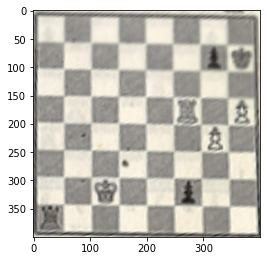

In [4]:
img = cv2.imread('../images/extracted.png')
px = 1/plt.rcParams['figure.dpi']
board_size = 300
plt.figure(figsize=(board_size*px, board_size*px))
plt.imshow(rgb(img))

- Use Canny for edge detection

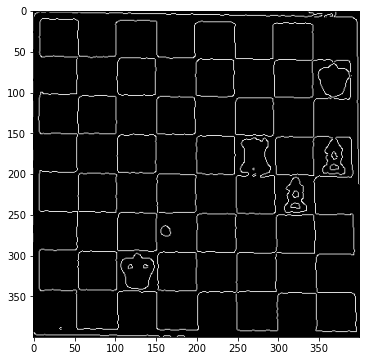

In [62]:
im_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
thresh, im_bw = cv2.threshold(im_gray, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
edges = cv2.Canny(im_bw, 50, 150)
plt.imshow(edges, 'gray')

- Find lines by using the standard Hough transform. This is done, iteratively, progressively decreasing the accumulator threshold parameter until there are at least 8 horizontal lines and 8 vertical lines. Lines that are too close to each other are ignore

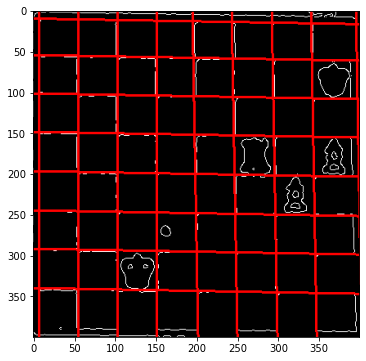

In [65]:
# Based on extract.extractGrid()

edges_copy = edges.copy()
nvertical = 8
nhorizontal = 8

height, width, _ = img.shape

horz_grid = width / nvertical
vert_grid = height / nhorizontal

tolerance = 0.2  # e.g. 0.2 => lines within 20% of the grid size will be filtered out?
vert_threshold = vert_grid * tolerance
horz_threshold = horz_grid * tolerance

hough_max = 150
hough_min = 50
hough_step = -20

horizontal = None
vertical = None
for threshold in range(hough_max, hough_min, hough_step):
    hough_lines = cv2.HoughLines(edges_copy, 1, np.pi/180, threshold)  # numpy array
    
    if hough_lines is None:
        continue

    lines = [line.Line(l[0], l[1]) for l in hough_lines.squeeze(axis=1)]  # list of Line objects
    
    horizontal, vertical = line.partitionLines(lines)
    vertical = line.filterCloseLines(vertical, horizontal=False, threshold=vert_threshold)
    horizontal = line.filterCloseLines(horizontal, horizontal=True, threshold=horz_threshold)

    if len(vertical) >= nvertical and len(horizontal) >= nhorizontal:
        break


if horizontal and vertical:
    red = (0, 0, 255)
    thickness = 2
    edges_copy = cv2.cvtColor(edges_copy, cv2.COLOR_GRAY2BGR)
    for v in vertical:
        v.draw(edges_copy, red, thickness)
    for h in horizontal:
        h.draw(edges_copy, red, thickness)
        
plt.imshow(rgb(edges_copy))

- Calculate lines intersections

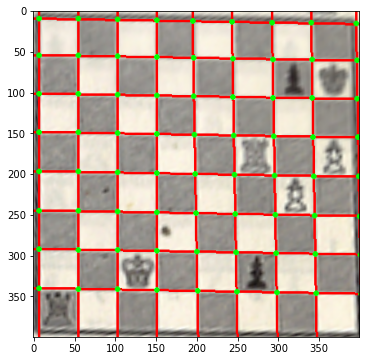

In [79]:
imgcopy = img.copy()
thickness = 2
green = (0, 255, 0)
intersections = []
if horizontal and vertical:
    for v in vertical:
        v.draw(imgcopy, red, thickness)
        for h in horizontal:
            h.draw(imgcopy, red, thickness)
            intersections.append(v.intersect(h))
    
    for i in intersections:
        util.drawPoint(imgcopy, i, green, radius=2, thickness=2)
        
plt.imshow(rgb(imgcopy))